<a href="https://colab.research.google.com/github/subh-775/Rice-Disease-Classification/blob/main/Rice_Disease_Renewed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
 

In [2]:
from datasets import load_dataset
dataset_dict = load_dataset("Subh775/Rice-Disease-Classification", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

rename.zip:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4078 [00:00<?, ? examples/s]

## Operations with Dataset


In [3]:
print(dataset_dict)

Dataset({
    features: ['image', 'label'],
    num_rows: 4078
})


In [4]:
# Get unique labels from the 'label' column
unique_labels = dataset_dict.unique('label')

#shuffle the order of the rows
dataset_dict = dataset_dict.shuffle(seed=42)

# Print unique labels
print("Unique labels:", unique_labels)


Unique labels: [0, 1, 2, 3]


In [5]:
#print((dataset_dict[7]))

2


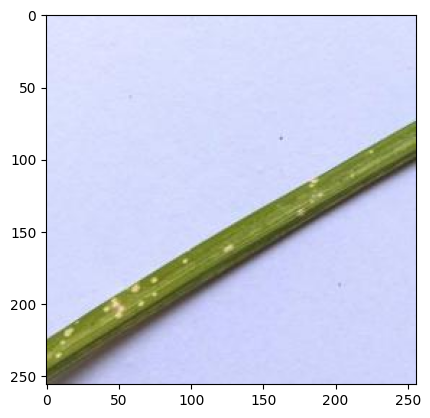

In [6]:
# Viewing specific image
from matplotlib.pyplot import imshow # Import imshow from matplotlib.pyplot
import matplotlib.pyplot as plt # Import matplotlib.pyplot for displaying the image

imshow(dataset_dict[408]['image']) # Assuming 'image' is the column name containing the image data
print(dataset_dict[408]['label'])
plt.show() # Display the image

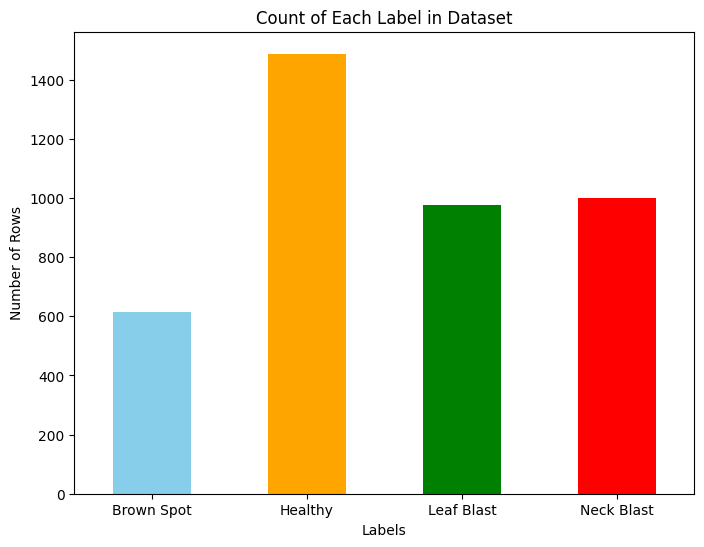

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the dataset into a Pandas DataFrame
df = pd.DataFrame(dataset_dict)   # recommended device type="TPU"

# Define a dictionary to map numerical labels to desired names
label_mapping = {
    0: "Brown Spot", # Brown Spot rice crops
    1: "Healthy",   # Healthy rice crops
    2: "Leaf Blast", # Leaf Blast rice crops
    3: "Neck Blast"  # Neck Blast rice crops
}

# Replace the numerical labels with the desired names using map()
df['label'] = df['label'].map(label_mapping)

# Count the occurrences of each renamed label
label_counts = df['label'].value_counts().sort_index()

# Plot the label counts
plt.figure(figsize=(8, 6))
label_counts.plot(kind="bar", color=["skyblue", "orange", "green", "red"])
plt.title("Count of Each Label in Dataset")
plt.xlabel("Labels")
plt.ylabel("Number of Rows")
plt.xticks(rotation=0)
plt.show()

## Training and Testing


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from datasets import DatasetDict

In [9]:
# Data augmentation and normalization for training, only normalization for testing
transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
#train_dataset = dataset_dict.select(range(100)).map(
#    lambda x: {"image": transform_train(x["image"]), "label": x["label"]}
#)
#
## Check for the correct validation split name in dataset_dict.keys()
## Common names include 'validation', 'test', 'eval', etc.
## For example, if the split is named 'validation':
#test_dataset = dataset_dict.select(range(100)).map(
#    lambda x: {"image": transform_test(x["image"]), "label": x["label"]}
#)
## Replace "validation" with the actual name if different.

# Conversion of image and labels into Tensor


In [11]:
from torch.utils.data import Dataset

class HuggingFaceDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and label
        image = self.dataset[idx]['image']  # Assuming 'image' column exists
        label = self.dataset[idx]['label']  # Assuming 'label' column exists

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
# Wrap the Hugging Face dataset with your custom class
train_hf_dataset = HuggingFaceDataset(dataset_dict, transform=transform_train)

# Split the dataset
train_size = int(0.9 * len(train_hf_dataset))
test_size = len(train_hf_dataset) - train_size

train_dataset, test_dataset = random_split(train_hf_dataset, [train_size, test_size])


In [13]:
print(len(train_dataset))
print(len(test_dataset))
print(train_size)
print(test_size)

3670
408
3670
408


In [14]:
#create dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Example of using the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)  # Check the shapes
    break

torch.Size([512, 3, 224, 224]) torch.Size([512])


#tensor conversion ending

In [15]:
##train_dataset = datasets.ImageFolder(main_dir, transform=transform_train)
#
## Split the dataset into 90% training and 10% validation
#train_size = int(0.9 * len(train_dataset))
#test_size = len(train_dataset) - train_size
#train_dataset, _ = random_split(train_dataset, [train_size, test_size])
#
##train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
#
## Apply transform_test to the test dataset
##test_dataset = datasets.ImageFolder(main_dir, transform=transform_test)
#_, test_dataset = random_split(test_dataset, [train_size, test_size])
##test_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [16]:
#print(dataset_dict.keys())

In [17]:
import wandb
# Initialize WandB
wandb.init(
    project="rice-disease-classification",  # Your project name
    name="resnet50-training",              # Optional run name
    config={                                # Configuration for tracking hyperparameters
        "learning_rate": 1e-4,
        "epochs": 50,
        "batch_size": 32,
        "architecture": "ResNet50",
    },
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
model = models.resnet50(pretrained=True)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer for our custom output size
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, len(unique_labels))
)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 69.5MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)# 1e4= 0.00001

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = running_corrects.double() / total

    #validation_loop
    model.eval()
    running_corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_accuracy = running_corrects.double() / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

torch.save(model.state_dict(), "Rice_disease.pth")
print("Model saved successfully!")

print(f"Validation Accuracy: {100 * running_corrects / total:.2f}%")

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "rice_disease100.pth") #resnet50_rice_disease.pth

print("Model saved successfully!")

In [ ]:
# Load the pre-trained ResNet50
model = models.resnet50(pretrained=False)  # Set pretrained=False when loading saved weights

# Modify the final layer to match your dataset's number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the saved state dictionary
model.load_state_dict(torch.load("resnet50_rice_disease.pth"))

# Move the model to the appropriate device
model.to(device)

print("Model loaded successfully!")